**LSTM** stands for Long-Short Term Memory. LSTM is a type of recurrent neural network but is better than traditional recurrent neural networks in terms of memory.<br>
LSTM has a memory cell that can maintain its state over time. The **memory cell is a crucial component** of a Long Short-Term Memory (LSTM) network. It is **responsible for storing information over long periods** of time and **selectively remembering or forgetting that information.**<br>

The memory cell is like a conveyor belt. Information can be written onto the belt, and it stays there until it is overwritten or erased. 



**Simple RNN:**

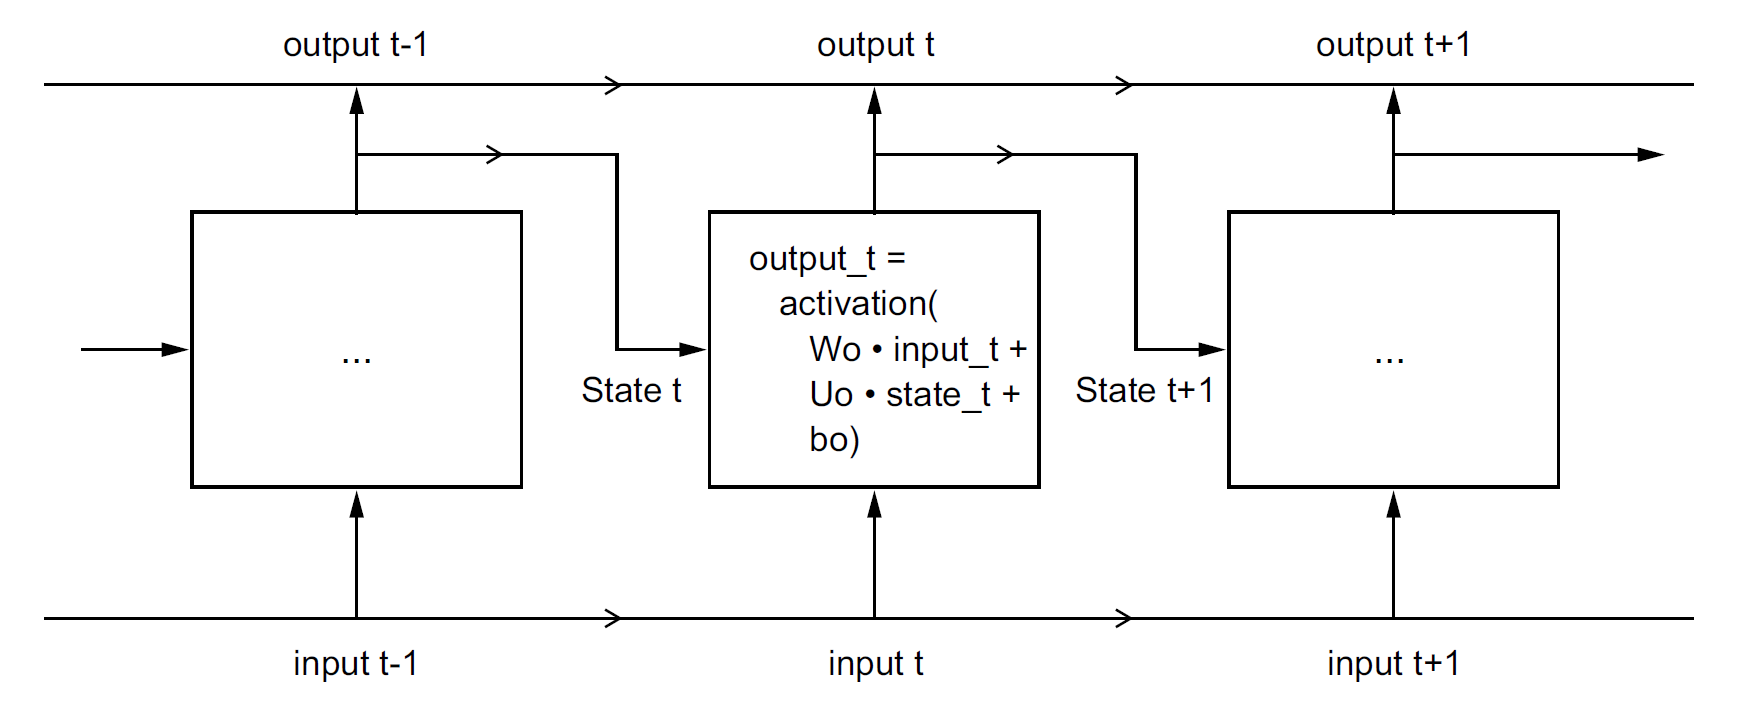

**Adding a carry track:**<br>
C stands for carry<br>
Conceptually, the carry dataflow is a way to modulate the next output and the next state.

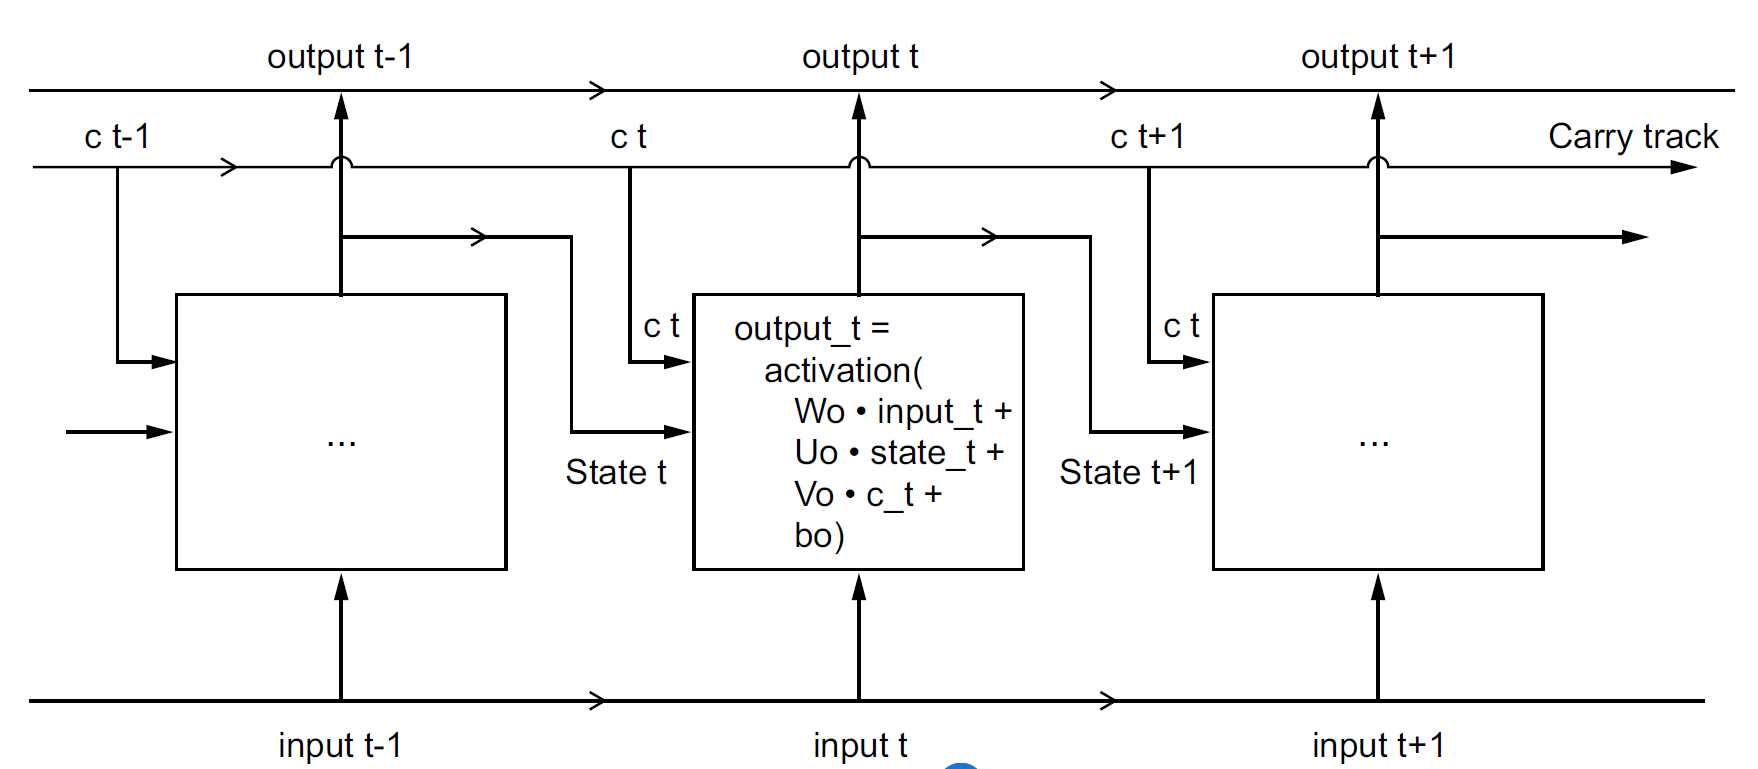

The way the next value of the carry dataflow is computed:<br>
It involves three distinct transformations. All three have the form of a SimpleRNN cell: <br>
y = activation(dot(state_t, U) + dot(input_t, W) + b)<br>
But all three transformations have their own weight matrices, which we’ll index with the letters i, f, and k.

The way the next value of the carry dataflow is computed:<br>
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)<br>
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)<br>
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)<br>
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)<br>
c_t+1 = i_t * k_t + c_t * f_t

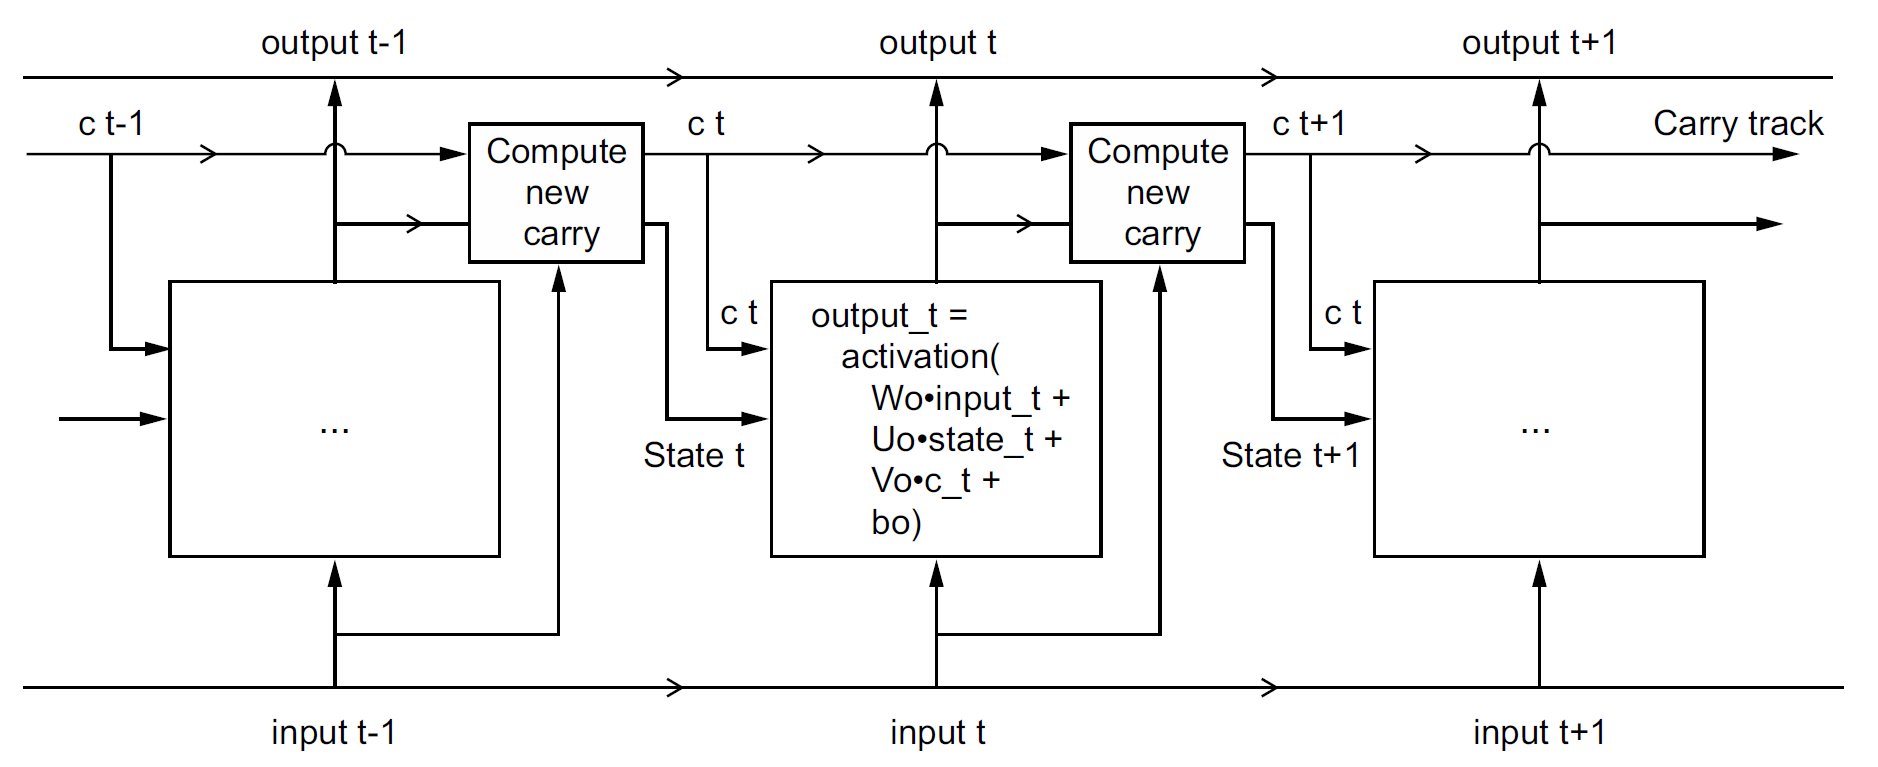

you can say that multiplying c_t and f_t is a way to deliberately
forget irrelevant information in the carry dataflow. Meanwhile, i_t and k_t provide information about the present, updating the carry track with new information.

forget gate. Here we will decide which bits of the cell state (long term memory of the network) are useful given both the previous hidden state and new input data.
* To do this, the previous hidden state and the new input data are fed into a neural network. This network generates a vector where each element is in the interval [0,1] (ensured by using the sigmoid activation). This network (within the forget gate) is trained so that it outputs close to 0 when a component of the input is deemed irrelevant and closer to 1 when relevant. It is useful to think of each element of this vector as a sort of filter/sieve which allows more information through as the value gets closer to 1.

* These outputted values are then sent up and pointwise multiplied with the previous cell state. This pointwise multiplication means that components of the cell state which have been deemed irrelevant by the forget gate network will be multiplied by a number close to 0 and thus will have less influence on the following steps.

input gate: The goal of this step is to determine what new information should be added to the networks long-term memory (cell state), given the previous hidden state and new input data.


In [ ]:
import keras
import tensorflow as tf
from keras import layers

In [ ]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
"path/train", batch_size=batch_size
)

test_ds = keras.utils.text_dataset_from_directory(
"path/test", batch_size=batch_size
)

#Running this line should output “Found 20000 files belonging to 2 classes”

In [ ]:
max_length = 600
max_tokens = 20000

text_vectorization = layers.TextVectorization(
max_tokens=max_tokens,
output_mode="int",
output_sequence_length=max_length,
)

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x) # Prepare a dataset that only yields raw text inputs (no labels)

The map() method is used to apply a lambda function to each element of train_ds. In this case, the lambda function takes each (x, y) pair in train_ds and returns only the x component, which is the string of text.

In [ ]:
text_vectorization.adapt(text_only_train_ds) #Use that dataset to index the dataset vocabulary via the adapt() method

In [ ]:
int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y),num_parallel_calls=4)
int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y),num_parallel_calls=4)

The lambda function takes each pair of inputs x and y in train_ds and returns a tuple containing two elements:<br>
1. The text_vectorization layer applied to the input x, which converts the text to integer sequences of fixed length defined by output_sequence_length=max_length in the text_vectorization layer.
2. The corresponding label y

The num_parallel_calls argument specifies the number of parallel threads to use for processing the elements of the dataset. In this case, num_parallel_calls=4 means that the lambda function will be applied to four elements of the dataset simultaneously.

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64") #This creates a Keras input layer that can accept sequences of integers with variable length (shape=(None,))

embedded = tf.one_hot(inputs, depth=max_tokens) #one-hot encodes the input sequences, converting each integer to a binary vector of length max_tokens with all zeros and a single one

x = layers.LSTM(32)(embedded)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.fit(int_train_ds, validation_data=int_test_ds, epochs=10)